# 3.1 Build models

In [51]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
import os

def sound():
    os.system('afplay /System/Library/Sounds/Sosumi.aiff')

%matplotlib inline
# sns.set_context('notebook')

path = '/'.join(os.getcwd().split('/')[:-1])
print(path)

/Volumes/Dropbox/largetransfer/luc/carter


In [52]:
df = pd.read_csv(path+'/data/model_data/tci_final.csv',index_col=0)

In [53]:
df.shape

(113132, 59)

In [54]:
list(df.columns)

['vacant',
 'cqual_num',
 'occup',
 'rnumstor',
 'propsize',
 'totusabl',
 'tmktval',
 'condition_value13',
 'condition_value14',
 'ownerocc_value',
 'LATITUDE',
 'LONGITUDE',
 'totbldgs',
 'yrbuilt_filtered',
 'vacant_block',
 'median_rent',
 'property_crimes',
 'burglaries',
 'part_one_crimes',
 'part_two_crimes',
 'bachelors+',
 'poverty_rate',
 'median_hh_income',
 'white',
 'black',
 'asian',
 'other',
 'hispanic',
 'young',
 'middle',
 'old',
 'lb_acquired',
 'lb_tax_fc',
 'TOTAL_NET_DELQ_BALANCE',
 'TAX_ASSESSED_LAND',
 'TAX_MARKET_LAND',
 'GRAND_TOTAL_BALANCE',
 'GRAND_TOTAL_PAID',
 'delq_total_ratio',
 'paid_percent',
 'GRAND_TOTAL_BALANCE_14',
 'pv_count',
 'v_total_1yr',
 'v_total_2yr',
 'days_since_ovv',
 'c_ovv_num',
 'days_since_ovv_board_up',
 'c_ovv_board_num',
 'active_fc',
 'fc_1yr',
 'fc_2yr',
 'fc_days',
 'sa_days',
 't_days',
 't_shf_deed',
 't_num',
 'al_num',
 'al_days',
 'price_per_sqft']

In [55]:
t = list(df.columns)
for i in ['vacant_block','median_rent','property_crimes','burglaries',\
          'part_one_crimes','part_two_crimes','bachelors+','poverty_rate','median_hh_income',\
          'white','black','asian','other','hispanic','young','middle','old']:
    t.remove(i)

In [56]:
features = t
features.remove('vacant')

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[features], df['vacant'], test_size=0.2, random_state=42)

## Build the classifiers

### Random Forest Classifier

In [57]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=8, min_samples_split=3, \
                                 class_weight={0:1, 1:7}, \
                                 max_features=20, random_state=0, max_depth=40)
rfc = rfc.fit(X_train, y_train)
sound()

In [58]:
# pd.crosstab(y_test, rfc.predict(X_test),rownames=['From survey'],colnames=['From model'],margins=True)
pd.crosstab(y_test,rfc.predict(X_test),colnames=['predicted by RF'])

predicted by RF,0,1
vacant,,
0,19803,791
1,752,1281


In [59]:
dat = pd.DataFrame([rfc.predict_proba(X_test)[:,1], y_test, rfc.predict(X_test)]).T
dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})

# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

acc_neg = len(dat[(dat.act==0) & (dat.pred==0)])/len(dat[dat.act==0])
acc_pos = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.act==1])
G = {}
F = {}
G['res'] = (acc_neg*acc_pos)**0.5
prec = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.pred==1])
F['res'] = 2*prec*acc_pos/(prec+acc_pos)
print(G, F, prec, acc_pos)

{'res': 0.7783967519884827} {'res': 0.6241169305724725} 0.6182432432432432 0.6301032956222331


In [60]:
# results = pd.DataFrame()
# for j in range(2,6):
#     rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=2*i, min_samples_split=3, \
#                                      class_weight={0:1, 1:8}, \
#                                      max_features=20, random_state=0, max_depth=40)
#     rfc = rfc.fit(X_train, y_train)
#     res = {}
#     for i in range(0,21):
#         # copy = y_test.copy()
#         p = i/20
#         copy = pd.Series(rfc.predict_proba(X_test)[:,1],index=y_test.index)
#         res[p] = {('correct_'+str(2*j)): sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#                   ('searched_'+str(2*j)): len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#                   ('percent_'+str(2*j)): sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     #     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
#     res = pd.DataFrame(res).T
#     results = pd.concat([results,res], axis=1)#, axis=1,keys=['a','b'])
# #     plt.plot(res.index, res.percent)
# sound()

In [61]:
res = {}
for i in range(0,21):
    # copy = y_test.copy()
    p = i/20
    copy = pd.Series(rfc.predict_proba(X_test)[:,1],index=y_test.index)
    res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
res = pd.DataFrame(res).T

# plt.plot(res.index, res.percent)

In [62]:
# from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
# from time import time
# from operator import itemgetter
# from scipy.stats import randint as sp_randint

# param_dist = {"max_depth": sp_randint(10, 50),
#               "max_features": sp_randint(5, 15),
#               "min_samples_split": sp_randint(1, 11),
#               "min_samples_leaf": sp_randint(1, 11),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

# n_iter_search = 20
# random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
#                                    n_iter=n_iter_search)

# start = time()
# random_search.fit(train[features], y)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))


In [63]:
# # Utility function to report best scores
# def report(grid_scores, n_top=3):
#     top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
#     for i, score in enumerate(top_scores):
#         print("Model with rank: {0}".format(i + 1))
#         print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#               score.mean_validation_score,
#               np.std(score.cv_validation_scores)))
#         print("Parameters: {0}".format(score.parameters))
#         print("")
# report(random_search.grid_scores_)

In [64]:
# tem = pd.DataFrame(rfc.predict_proba(test[features]))
# tem['vacant'] = test['vacant'].values
# tem = tem.sort_values(1, ascending=False)
# test.loc[:,'pred'] = rfc.predict(test[features])

In [65]:
# def fun(x):
#     if (x.pred == 1) & (x.vacant == 1):
#         return 'TP'
#     elif (x.pred == 1):
#         return 'FP'
#     elif (x.vacant == 1):
#         return 'FN'
#     else:
#         return 'TN'
# test.loc[:,'cat'] = test.apply(fun, axis=1)

In [66]:
# y2,_= pd.factorize(train.loc[train.index.isin(df[df.SPA_NAME.isin(west)].index)].vacant)

# rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=10, min_samples_split=2, \
#                                  class_weight={0:1, 1:1}, \
#                                  max_features=10, random_state=0, max_depth=20)
# rfc = rfc.fit(train.loc[train.index.isin(df[df.SPA_NAME.isin(west)].index),features], y2)
# sound()
# print(pd.crosstab(test[test.index.isin(df[df.SPA_NAME.isin(west)].index)].vacant, \
#                   rfc.predict(test.loc[test.index.isin(df[df.SPA_NAME.isin(west)].index),features])))

In [67]:
# west = ['Bellaire-Puritas','Brooklyn Centre','Clark-Fulton','Cudell','Detroit Shoreway','Edgewater'\
#        ,'Jefferson',"Kamm's",'Ohio City','Old Brooklyn','Stockyards','Tremont','West Boulevard']
# cols = ['GRAND_TOTAL_BALANCE','TAX_MARKET_LAND','sa_days','fc_days','c_ovv_2yr','pv_total',\
#         'tmktval','propsize','condition_value14','median_rent']

## Importances

Feature ranking:
1. feature 26, days_since_ovv (0.242518)
2. feature 23, pv_count (0.100683)
3. feature 27, c_ovv_num (0.091739)
4. feature 19, GRAND_TOTAL_PAID (0.083065)
5. feature 21, paid_percent (0.051185)
6. feature 34, sa_days (0.037114)
7. feature 33, fc_days (0.037080)
8. feature 10, LONGITUDE (0.024850)
9. feature 40, price_per_sqft (0.023435)
10. feature 5, tmktval (0.021919)


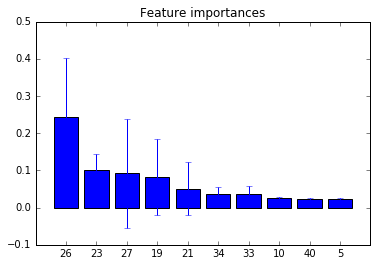

In [68]:
# plot the top ten features

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Feature ranking (least important):
1. feature 29, c_ovv_board_num (0.000000)
2. feature 13, lb_acquired (0.000003)
3. feature 14, lb_tax_fc (0.000016)
4. feature 30, active_fc (0.000235)
5. feature 31, fc_1yr (0.000710)
6. feature 11, totbldgs (0.001013)
7. feature 1, occup (0.002287)
8. feature 2, rnumstor (0.003292)
9. feature 32, fc_2yr (0.003645)
10. feature 0, cqual_num (0.004176)


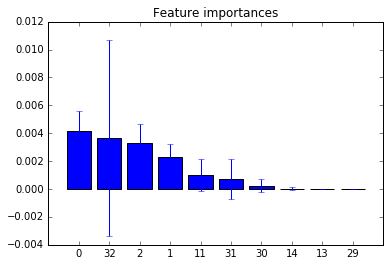

In [69]:
# Print the feature ranking
features2 = pd.DataFrame(features).iloc[indices[0:10]][0].values

print("Feature ranking (least important):")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[-10:]], yerr=std[indices[-10:]], align="center")
plt.xticks(range(10), indices[-10:])
plt.xlim([-1, 10])
plt.show()

### Logistic Regressor

In [70]:
# features2 = ['c_O.V.V._2yr', 'pv_total','GRAND_TOTAL_BALANCE','condition_value','vacant',\
#              'totusabl', 'tmktval', 'fc_days', 'days_since_transfer', 'propsize', 'yrbuilt_filtered', 'al_days']

# # features2 = ['c_O.V.V._2yr', 'pv_total','GRAND_TOTAL_BALANCE','condition_value','vacant']

In [71]:
# train_lr = preprocessing.scale(X_train)
# test_lr = preprocessing.scale(X_test)

# lr = LogisticRegression(class_weight={0:1, 1:2}, random_state=1001)
# lr.fit(pd.DataFrame(train_lr, columns = features), y_train)
# pd.crosstab(y_test,lr.predict(test_lr))

In [72]:
lr = LogisticRegression(class_weight={0:1, 1:3}, random_state=1001)
lr.fit(pd.DataFrame(X_train, columns = features), y_train)
# pd.crosstab(y_test,lr.predict(X_test))

pd.crosstab(y_test,lr.predict(X_test),colnames=['predicted by LR'])

predicted by LR,0,1
vacant,,
0,19824,770
1,811,1222


In [73]:
dat = pd.DataFrame([lr.predict_proba(X_test)[:,1], y_test, lr.predict(X_test)]).T
dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})

# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

acc_neg = len(dat[(dat.act==0) & (dat.pred==0)])/len(dat[dat.act==0])
acc_pos = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.act==1])
G['log_res'] = (acc_neg*acc_pos)**0.5
prec = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.pred==1])
F['log_res'] = 2*prec*acc_pos/(prec+acc_pos)
print(G, F, prec, acc_pos)

{'res': 0.7783967519884827, 'log_res': 0.760662845928178} {'res': 0.6241169305724725, 'log_res': 0.6072049689440994} 0.6134538152610441 0.6010821446138711


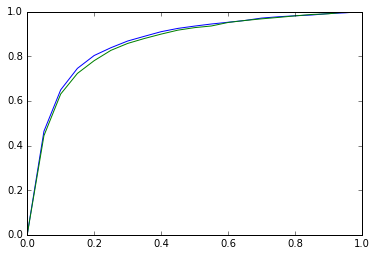

In [74]:
log_res = {}
for i in range(0,21):
    # copy = y_test.copy()
    p = i/20
    copy = pd.Series(lr.predict_proba(X_test)[:,1],index=y_test.index)
    log_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
log_res = pd.DataFrame(log_res).T

plt.plot(res.index, res.percent)
plt.plot(log_res.index, log_res.percent)

In [75]:
importances = lr.coef_[0]
# std = np.std([tree.feature_importances_ for tree in lr.estimators_],
#              axis=0)
indices = np.argsort(abs(importances))[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(15):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
print("\nFeature ranking (least important):")
for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))

Feature ranking:
1. feature 23, pv_count (0.176926)
2. feature 25, v_total_2yr (0.056771)
3. feature 7, condition_value14 (-0.045717)
4. feature 24, v_total_1yr (0.044734)
5. feature 6, condition_value13 (-0.039652)
6. feature 0, cqual_num (-0.013608)
7. feature 8, ownerocc_value (-0.011403)
8. feature 40, price_per_sqft (-0.008549)
9. feature 20, delq_total_ratio (0.008419)
10. feature 10, LONGITUDE (0.007999)
11. feature 21, paid_percent (-0.006334)
12. feature 12, yrbuilt_filtered (-0.004869)
13. feature 1, occup (0.003919)
14. feature 9, LATITUDE (-0.003223)
15. feature 2, rnumstor (-0.003072)

Feature ranking (least important):
1. feature 29, c_ovv_board_num (0.000000)
2. feature 36, t_shf_deed (0.000005)
3. feature 5, tmktval (-0.000015)
4. feature 3, propsize (-0.000019)
5. feature 22, GRAND_TOTAL_BALANCE_14 (0.000028)
6. feature 17, TAX_MARKET_LAND (0.000040)
7. feature 19, GRAND_TOTAL_PAID (-0.000052)
8. feature 39, al_days (0.000108)
9. feature 4, totusabl (0.000129)
10. feat

### Gradient boosted classifier

In [76]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# est = GradientBoostingClassifier(n_estimators=300, learning_rate=0.7,
#     max_depth=1, random_state=0).fit(X_train, y_train)
# clf.score(train[features], y)                 

In [77]:
# from sklearn.ensemble import GradientBoostingClassifier

# est = GradientBoostingClassifier(n_estimators=500, learning_rate=0.7,
#     max_depth=1, random_state=0).fit(X_train, y_train)
# # clf.score(train[features], y)                 
# pd.crosstab(y_test, est.predict(X_test))

In [78]:
# dat = pd.DataFrame([est.predict_proba(X_test)[:,1], y_test, est.predict(X_test)]).T
# dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})

# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

In [79]:
# gbm_res = {}
# for i in range(0,21):
#     # copy = y_test.copy()
#     p = i/20
#     copy = pd.Series(est.predict_proba(X_test)[:,1],index=y_test.index)
#     gbm_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#               'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#               'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
# #     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
# gbm_res = pd.DataFrame(gbm_res).T

# plt.plot(res.index, res.percent)
# plt.plot(log_res.index, log_res.percent)
# plt.plot(gbm_res.index, gbm_res.percent)
# plt.legend(['Random forest','Logistic regression','Gradient boosted trees'],loc='lower right');

In [80]:
# n_estimators = len(est.estimators_)

# def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6',
#                   test_color='#d7191c', alpha=1.0):
#     """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
#     test_dev = np.empty(n_estimators)

#     for i, pred in enumerate(est.staged_predict(X_test)):
#        test_dev[i] = est.loss_(y_test, pred)

#     if ax is None:
#         fig = plt.figure(figsize=(7, 5))
#         ax = plt.gca()

#     ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label,
#              linewidth=2, alpha=alpha)
#     ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color,
#              label='Train %s' % label, linewidth=2, alpha=alpha)
#     ax.set_ylabel('Error')
#     ax.set_xlabel('n_estimators')
# #     ax.set_ylim((0, 2))
#     return test_dev, ax

# test_dev, ax = deviance_plot(est, X_test, y_test)
# ax.legend(loc=[0.8,0.8])

# # add some annotations
# # ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02), xycoords='data',\
# #             xytext=(50, 1.0), textcoords='data',\
# #             arrowprops=dict(arrowstyle="->", connectionstyle="arc"),\
# #             )

# ann = ax.annotate('', xy=(150, test_dev[149]),  xycoords='data',\
#                   xytext=(150, est.train_score_[149]), textcoords='data',\
#                   arrowprops=dict(arrowstyle="<->"))
# ax.text(160, 0.85, 'train-test gap')

In [81]:
# fig = plt.figure(figsize=(8, 5))
# ax = plt.gca()
# for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
#                                           ({'learning_rate': 0.1},
#                                            ('#fdae61', '#abd9e9'))]:
#     est = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
#     est.set_params(**params)
#     est.fit(X_train, y_train)

#     test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
#                                  train_color=train_color, test_color=test_color)

# ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), xycoords='data',
#             xytext=(300, 1.0), textcoords='data',
#             arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
#             )
# ax.annotate('Lower test error', xy=(900, test_dev[899]), xycoords='data',
#             xytext=(600, 0.5), textcoords='data',
#             arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
#             )
# plt.legend(loc='upper right')

In [82]:
# abc = AdaBoostClassifier(random_state=0)
# abc.fit(X_train, y_train)
# pd.crosstab(y_test, abc.predict(X_test), rownames=['actual'], colnames=['preds'])

In [83]:
# abc_res = {}
# for i in range(0,21):
#     # copy = y_test.copy()
#     p = i/20
#     copy = pd.Series(abc.predict_proba(X_test)[:,1],index=y_test.index)
#     abc_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#               'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#               'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
# #     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
# abc_res = pd.DataFrame(abc_res).T

In [84]:
# sns.set_context('notebook')
# plt.plot(res.index, res.percent)
# plt.plot(log_res.index, log_res.percent)
# plt.plot(xgb_res.index, xgb_res.percent)
# plt.plot(abc_res.index, abc_res.percent)
# plt.plot([0,sum(y_test)/len(y_test)],[0,1],'k--',linewidth=1)
# plt.xlabel('Fraction of homes inspected')
# plt.ylabel('Fraction of vacant identified')
# # plt.set_xticklabels(fontsize='small')
# # plt.axis([-0.05,1.05,-0.05,1.05])
# plt.legend(['Random forest','Logistic regression','Gradient boosted trees','Perfect classifier'],loc='lower right');
# plt.savefig(path+'/outputs/model_inspection_comparison.ps')

### Single decision tree

In [85]:
# from sklearn import tree

In [86]:
# leafs = range(1,20,1)
# scores = []
# for leaf in leafs:
#     clf = tree.DecisionTreeClassifier(class_weight='auto', min_samples_leaf=leaf)
#     scores.append(cross_val_score(clf, df[features], df.vacant, cv=10, scoring='accuracy').mean())
# plt.plot(leafs, scores, '--');

In [87]:
# clf = tree.DecisionTreeClassifier(class_weight={0:1,1:2}, min_samples_leaf=12)
# clf = clf.fit(X_train, y_train)

In [88]:
# pd.crosstab(y_test, clf.predict(X_test), rownames=['actual'], colnames=['preds'])

## xgboost

In [89]:
import xgboost as xgb

xgtest = X_test.as_matrix()
#create train and validation dmatrices 
xgtrain = X_train.as_matrix()

gbm = xgb.XGBClassifier(seed=0).fit(xgtrain, y_train)
predictions = gbm.predict(xgtest)
probs = gbm.predict_proba(xgtest)
pd.crosstab(y_test,predictions)

col_0,0,1
vacant,,
0,20342,252
1,1027,1006


In [90]:
# t = X_test.copy()

In [91]:
# from sklearn.externals import joblib
# joblib.dump(gbm, path+'/data/models/gbm.pkl') 

In [92]:
# sum(clf123.predict(xgtest))

In [93]:
# import pickle
# s = pickle.dumps(gbm)
# clf2 = pickle.loads(s)
# clf2.predict(xgtrain)


In [94]:
# gbm.save_model(path+'/data/models/')

In [96]:
# t[['preds']].to_csv(path+'/data/predictions/xgb.csv')

In [105]:
pd.crosstab(y_test,pd.Series(probs[:,1]+.225).apply(lambda x: int(round(x))).values,rownames=['actual'],colnames=['predicted by GBM'])

predicted by GBM,0,1
actual,,
0,19941,653
1,788,1245


In [98]:
xgb_res = {}
for i in range(0,21):
    # copy = y_test.copy()
    p = i/20
    copy = pd.Series(probs[:,1]+.22)
#     copy = pd.Series(probs[:,1],index=y_test.index)
    xgb_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
xgb_res = pd.DataFrame(xgb_res).T

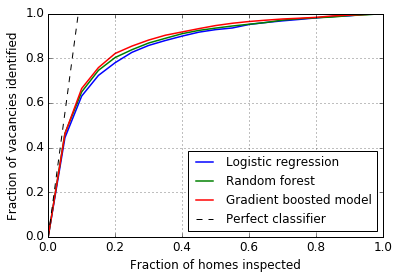

In [99]:
# sns.set_context('notebook')
# sns.set_style("whitegrid")
fig = plt.figure()
# fig, ax = plt.subplots()
# ax.plot(t, s)

plot = fig.add_subplot(111)
# ax.grid(True)
ax = fig.gca()
ax.grid(True)
plot.tick_params(axis='both', labelsize=12)
plt.plot(log_res.index, log_res.percent,linewidth=1.5)
plt.plot(res.index, res.percent,linewidth=1.5)
plt.plot(xgb_res.index, xgb_res.percent,linewidth=1.5)
plt.plot([0,sum(y_test)/len(y_test)],[0,1],'k--',linewidth=1)
plt.xlabel('Fraction of homes inspected',fontsize=12)
plt.ylabel('Fraction of vacancies identified',fontsize=12)
# plt.set_xticklabels(fontsize='small')
# plt.axis([-0.05,1.05,-0.05,1.05])
plt.legend(['Logistic regression','Random forest','Gradient boosted model','Perfect classifier'],loc='lower right',fontsize=12);
# plt.savefig(path+'/outputs/model_inspection_comparison.pdf')

In [100]:
xgtrain.shape

(90505, 41)

In [101]:
tem = pd.concat([res[['correct']].iloc[range(0,22,2)], \
           log_res[['correct']].iloc[range(0,22,2)],\
           xgb_res[['correct']].iloc[range(0,22,2)] ], axis=1)

tem.columns = ['Random forest','Logistic regression','Gradient boosted']

tem

,Random forest,Logistic regression,Gradient boosted
0.0,0,0,0
0.1,1320,1282,1351
0.2,1633,1586,1670
0.3,1765,1743,1792
0.4,1850,1828,1866
0.5,1901,1887,1924
0.6,1936,1934,1961
0.7,1974,1967,1984
0.8,1995,1994,1999
0.9,2015,2013,2019


In [102]:
dat = pd.DataFrame([gbm.predict_proba(X_test)[:,1]+0.22, y_test, pd.Series(probs[:,1]+.23).apply(lambda x: int(round(x))).values]).T
dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})


# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

acc_neg = len(dat[(dat.act==0) & (dat.pred==0)])/len(dat[dat.act==0])
acc_pos = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.act==1])
G['xgb_res'] = (acc_neg*acc_pos)**0.5
prec = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.pred==1])
F['xgb_res'] = 2*prec*acc_pos/(prec+acc_pos)
print(G, F, prec, acc_pos)

{'xgb_res': 0.7734031966899635, 'res': 0.7783967519884827, 'log_res': 0.760662845928178} {'xgb_res': 0.6346882100479677, 'res': 0.6241169305724725, 'log_res': 0.6072049689440994} 0.6519709543568465 0.6182980816527299


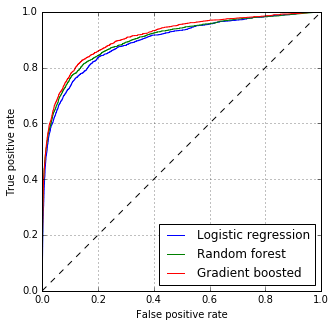

In [103]:
from sklearn.metrics import roc_curve

fig = plt.figure(figsize=[5,5])
plot = fig.add_subplot(111)

ax = fig.gca()
ax.grid(True)


# The logistic regression
y_pred_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

# The random forest model by itself
y_pred_rf = rfc.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# The random forest model by itself
y_pred_gb = gbm.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)

plt.plot(fpr_lr, tpr_lr, label='Logistic regression')
plt.plot(fpr_rf, tpr_rf, label='Random forest')
plt.plot(fpr_gb, tpr_gb, label='Gradient boosted')
plt.plot([0,1], [0,1],'k--')

plt.legend(loc='lower right');
plt.axis([0,1,0,1],'equal')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

# plt.savefig(path+'/outputs/model_ROC.pdf')